In this notebook we will implement a simplified version of the DCM model, in order to generate data for subsequent examples.

In [7]:
import numpy
# use a consistent seed so that everyone has the same data
numpy.random.seed(1000)

import os,sys
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../utils')
from mkdesign import create_design_singlecondition
import scipy.interpolate
from scipy.integrate import odeint
import math
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)


In [13]:
# first let's build the model without the bilinear influence (aka PPI)
# after http://spm.martinpyka.de/?p=81
nregions=5
z=numpy.zeros(nregions)

# intrinsic connectivity
A=numpy.zeros((z.shape[0],z.shape[0]))
A=numpy.diag(numpy.ones(z.shape[0])*-1)
# add some structure
#A=A + numpy.diag(numpy.ones(z.shape[0]-1),k=-1)
A[2,1]=1
A[3,1]=1
B=numpy.zeros(A.shape)
B[2,0]=1
B[4,0]=1

C=numpy.zeros((z.shape[0],1))
C[0]=1
u=0

print A
print B
print C

# we are assuming a 1 second TR for the resulting data
# but the neural data are at a 1/16 millisecond time resolution
stepsize=.01
tslength=300
timepoints=numpy.arange(0,tslength,stepsize)

# create a blocked design
d,design=create_design_singlecondition(blockiness=1.0,deslength=tslength,blocklength=20,offset=20)

u=scipy.interpolate.griddata(numpy.arange(1,d.shape[0]),d,timepoints,fill_value=0)

def dcm_model(t,z,A,B,C,u):
    ut=numpy.abs(timepoints - t).argmin() 
    return (A.dot(z)+ u[ut]*B.dot(z) + C.dot(u[ut]).T)[0] 

def mk_dcm_dataset(timepoints,z,noise_sd):
    data=numpy.zeros((len(timepoints),len(z)))
    for i in range(1,len(timepoints)):
        data[i,:]=data[i-1,:] + dcm_model(timepoints[i],data[i-1,:],A,B,C,u)  + numpy.random.randn(len(z))*noise_sd 
    hrf=spm_hrf(stepsize,oversampling=1)
    data_conv=numpy.zeros(data.shape)
    for i in range(len(z)):
        data_conv[:,i]=numpy.convolve(data[:,i],hrf)[:data.shape[0]]        
    return data,data_conv    

[[-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [14]:
noise_sd=10
data,data_conv=mk_dcm_dataset(timepoints,z,noise_sd)
numpy.savez(os.path.join(results_dir,'dcmdata.npz'),data=data_conv,A=A,B=B,C=C,u=u)

correlation matrix
[[ 1.          0.13522856  0.68692077  0.00933663  0.67983364]
 [ 0.13522856  1.          0.57576413  0.65835637  0.07671467]
 [ 0.68692077  0.57576413  1.          0.35185007  0.48027677]
 [ 0.00933663  0.65835637  0.35185007  1.          0.12701311]
 [ 0.67983364  0.07671467  0.48027677  0.12701311  1.        ]]
partial correlation matrix
[[ 0.          0.12346862 -0.57408255  0.16118098 -0.50989308]
 [ 0.12346862  0.         -0.46033387 -0.50880845  0.08378846]
 [-0.57408255 -0.46033387  0.         -0.07599893 -0.04390321]
 [ 0.16118098 -0.50880845 -0.07599893  0.         -0.11507731]
 [-0.50989308  0.08378846 -0.04390321 -0.11507731  0.        ]]


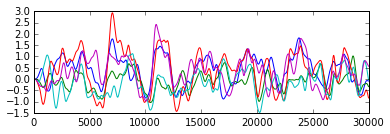

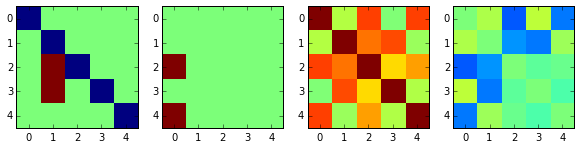

In [15]:
plt.subplot(211)
plt.plot(data_conv)
cc=numpy.corrcoef(data_conv.T)
print 'correlation matrix'
print cc
from sklearn.covariance import GraphLassoCV
import matplotlib.colors

glasso=GraphLassoCV()
glasso.fit(data_conv)
from pcor_from_precision import pcor_from_precision
pcor=pcor_from_precision(glasso.precision_)
print 'partial correlation matrix'
print pcor

plt.figure(figsize=(10,5))
plt.subplot(141)
plt.imshow(A,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.subplot(142)
plt.imshow(B,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.subplot(143)
plt.imshow(cc,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.subplot(144)
plt.imshow(pcor,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))


In [11]:
def show_graph_with_labels(adjacency_matrix):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    nodes=range(1,adjacency_matrix.shape[0]+1)
    gr.add_nodes_from(nodes)
    gr.add_edges_from(edges)
    print gr.nodes()
    mylabels={i:'%d'%i for i in gr.nodes()} # {(gr.nodes(),['%d'%i for i in gr.nodes()])
    nx.draw(gr, node_size=500, pos=nx.circular_layout(gr),labels=mylabels, with_labels=True)
    plt.show()
    return gr

[1, 2, 3, 4, 5]


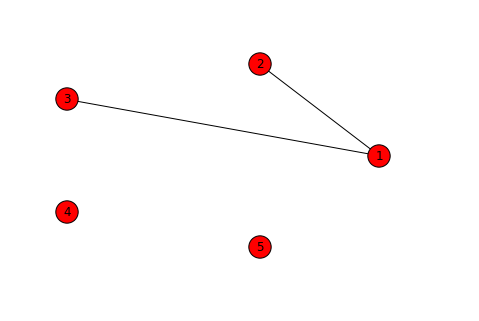

In [12]:
show_graph_with_labels(A)